## Generating facies realizations with GeostatsPy

We generate here a set of facies realizations (sand/ shale) using the fantastic geostatistical library _geostatspy_ (https://github.com/GeostatsGuy/GeostatsPy) by Michael Pyrcz (University of Texas, Austin).

The example is modified from his notebook https://github.com/GeostatsGuy/PythonNumericalDemos/GeostatsPy_sisim.ipynb

In [1]:
import os                                                 # to set current working directory 
import numpy as np                                        # arrays and matrix math
import pandas as pd                                       # DataFrames
import matplotlib.pyplot as plt                           # plotting
import geostatspy.GSLIB as GSLIB
import geostatspy.geostats as geostats



### Load Data

We are using a data set that is also provided by Michael Pyrcz on https://github.com/GeostatsGuy/GeoDataSets

In [132]:
df = pd.read_csv("sample_data_MV_biased.csv")             # read a .csv file in as a DataFrame
df.describe()                                             # summary statistics 
df = df.sample(50)                                        # extract 50 samples
df = df.reset_index()                                     # reset the record index 
df.head(n=10)

,index,Unnamed: 0,X,Y,Facies,Porosity,Perm,AI
0,312,486,0.0,549.0,1.0,0.173918,102.319997,3673.832356
1,269,428,680.0,429.0,1.0,0.116107,22.702807,6013.816976
2,84,133,140.0,499.0,1.0,0.138823,12.365241,3125.840089
3,303,476,340.0,739.0,1.0,0.146070,234.357400,3828.898027
4,5,9,200.0,900.0,1.0,0.129949,23.348473,4781.590782
5,242,393,100.0,419.0,1.0,0.119454,2.668077,4012.550053
6,299,469,280.0,159.0,0.0,0.104640,2.250848,6884.750503
7,173,279,870.0,919.0,1.0,0.110386,1.415355,3969.565896
8,189,306,610.0,189.0,0.0,0.118295,6.525972,5927.240472
9,344,541,940.0,949.0,0.0,0.102437,0.956152,4105.074357


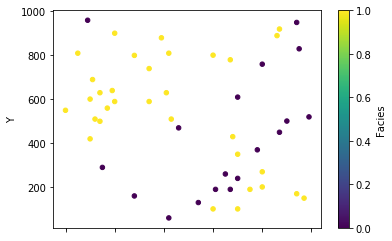

In [133]:
df.plot.scatter(x="X", y="Y", c="Facies", colormap='viridis')

In [134]:
vals = df[["X", "Y", "Facies"]].values

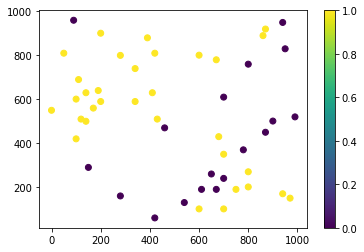

In [135]:
plt.scatter(vals[:,0], vals[:,1], c=vals[:,2])
plt.colorbar()

Generate a couple of new facies points (based on facies 1)


In [137]:
idx = np.where(vals[:,2] == 0)[0]
select = np.random.choice(idx, size=10, replace=False)

In [174]:
for s in select:
    vals[s,2] = 2

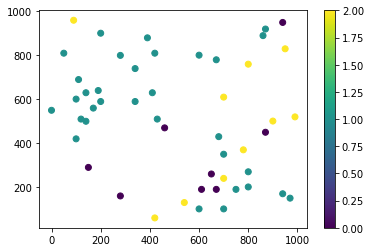

In [175]:
plt.scatter(vals[:,0], vals[:,1], c=vals[:,2])
plt.colorbar()

Update df:

In [176]:
df['Facies'] = vals[:,2]

### Generating Realizations

As a first step, we define the global model domain, the number of facies (with proportions) and the facies variograms:

In [191]:
# Sequential Indicator Simulation with Simple Kriging Multiple Realizations 
nx = 64; ny = 64; xsiz = 1000./nx; ysiz = 1000./ny; xmn = 10.0; ymn = 10.0; nxdis = 1; nydis = 1
ndmin = 0; ndmax = 10; nodmax = 10; radius = 400; skmean = 0.5
tmin = -999; tmax = 999
dummy_trend = np.zeros((11,11))            # the current version requires trend input - if wrong size it is ignored 

ncut = 3                                   # number of facies

if ncut == 2: # standard version
    thresh = [0,1]                             # the facies categories (use consistent order)
    gcdf = [0.4,0.6]                           # the global proportions of the categories
    varios = []                                # the variogram list
    varios.append(GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=90,hmaj1=400,hmin1=100)) # shale indicator variogram
    # varios.append(GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=0,hmaj1=100,hmin1=100)) # sand indicator variogram
    varios.append(GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=90,hmaj1=400,hmin1=100)) # sand indicator variogram

if ncut == 3: # adjusted for three facies (FW)
    thresh = [0,1,2]                             # the facies categories (use consistent order)
    # gcdf = [0.4,0.6]                           # the global proportions of the categories
    gcdf = [0.1,0.1,0.8]                           # the global proportions of the categories
    varios = []                                # the variogram list
    varios.append(GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=0.8,cc2=0.2,azi1=90,hmaj1=400,hmin1=100)) # shale indicator variogram
    # varios.append(GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=0,hmaj1=100,hmin1=100)) # sand indicator variogram
    varios.append(GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=0.8,cc2=0.2,azi1=90,hmaj1=400,hmin1=100)) # sand indicator variogram
    varios.append(GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=0.8,cc2=0.2,azi1=90,hmaj1=100,hmin1=100)) # facies 2 indicator variogram

    

Before we generate realizations, we set the random seed for later reproducibility (Technical side note: seeds need to be generated for subsequent implementation of GSLib functions):

In [206]:
n_realizations = 1000
np.random.seed(seed = 12345)
seeds = np.random.choice(10000, n_realizations, replace=False)
seeds

array([7867, 1402, 8606, 8885, 6494, 9628, 7459, 3964, 7000, 4470, 9996,
       1797, 4696,  716, 2188, 8613, 7553,  757, 1553, 3429, 8328, 7211,
       6835, 1137, 2827, 1757, 7872, 9124, 4851, 7308,  556, 6061, 3762,
       4371, 7001, 3474, 5623, 3819,  987, 9770, 5359, 9297, 7864, 6332,
       4318, 9026,  585, 3209, 9044, 9961, 8614, 2012,  951, 9037, 6221,
       4958, 9521, 3245, 4314, 3219, 1557, 7100, 8639, 4946, 5956, 5198,
       8092, 8085, 7300, 8580,  343, 5352, 4906,  239, 8866, 8381, 5368,
       7631, 6810,  313,  576, 2552, 7068, 4444,   15, 5027, 6492, 2147,
       6192, 2143, 3176, 1523, 8117, 5076,  680, 7922, 9987, 3444, 4960,
       2489, 7313, 5929, 3332, 9283, 5463, 1975,   29,  474, 8975, 4350,
        342, 9380, 3501, 7376, 5504,   28, 1817, 3258, 7727, 8448, 6699,
       4869,   34, 9360, 7006, 2061, 2395,  784, 8742, 6979, 1612, 9205,
       4674, 1895, 9242, 2241, 6603,  703, 5479, 1005, 7019, 8077, 9135,
       5885, 4394, 7667, 2786, 9473, 1594, 8564, 23

We now can generate realizations (approx. 10s per realization for settings above!):

In [ ]:
realizations = np.empty(shape=(n_realizations, nx, ny))

for i in range(n_realizations):
    
    # Added just for better checks during offline run:
    print("\n")
    print(80*"*")
    print("\n\n\t Realization %d \n\n"% i)
    print(80*"*")
    print("\n")
    
    realizations[i,:,:] = geostats.sisim(df,'X','Y','Facies',ivtype=0,koption=0,ncut=ncut,thresh=thresh,gcdf=gcdf,trend=dummy_trend,
                   tmin=tmin,tmax=tmax,zmin=0.0,zmax=1.0,ltail=1,ltpar=1,middle=1,mpar=0,utail=1,utpar=2,
                   nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=seeds[i],
                   ndmin=ndmin,ndmax=ndmax,nodmax=nodmax,mults=1,nmult=3,noct=-1,radius=radius,ktype=0,vario=varios)




********************************************************************************


	 Realization 0 


********************************************************************************


Data for IK3D: Variable column Facies
  Number   = 50
Setting up rotation matrices for variogram and search
Working on a single realization, seed 7867
   currently on node 0
   currently on node 2048


********************************************************************************


	 Realization 1 


********************************************************************************


Data for IK3D: Variable column Facies
  Number   = 50
Setting up rotation matrices for variogram and search
Working on a single realization, seed 1402
   currently on node 0
   currently on node 2048


********************************************************************************


	 Realization 2 


********************************************************************************


Data for IK3D: Variable column Facies
 

   currently on node 2048


********************************************************************************


	 Realization 22 


********************************************************************************


Data for IK3D: Variable column Facies
  Number   = 50
Setting up rotation matrices for variogram and search
Working on a single realization, seed 6835
   currently on node 0
   currently on node 2048


********************************************************************************


	 Realization 23 


********************************************************************************


Data for IK3D: Variable column Facies
  Number   = 50
Setting up rotation matrices for variogram and search
Working on a single realization, seed 1137
   currently on node 0
   currently on node 2048


********************************************************************************


	 Realization 24 


********************************************************************************


Data for I

   currently on node 2048


********************************************************************************


	 Realization 44 


********************************************************************************


Data for IK3D: Variable column Facies
  Number   = 50
Setting up rotation matrices for variogram and search
Working on a single realization, seed 4318
   currently on node 0
   currently on node 2048


********************************************************************************


	 Realization 45 


********************************************************************************


Data for IK3D: Variable column Facies
  Number   = 50
Setting up rotation matrices for variogram and search
Working on a single realization, seed 9026
   currently on node 0
   currently on node 2048


********************************************************************************


	 Realization 46 


********************************************************************************


Data for I

   currently on node 2048


********************************************************************************


	 Realization 66 


********************************************************************************


Data for IK3D: Variable column Facies
  Number   = 50
Setting up rotation matrices for variogram and search
Working on a single realization, seed 8092
   currently on node 0
   currently on node 2048


********************************************************************************


	 Realization 67 


********************************************************************************


Data for IK3D: Variable column Facies
  Number   = 50
Setting up rotation matrices for variogram and search
Working on a single realization, seed 8085
   currently on node 0
   currently on node 2048


********************************************************************************


	 Realization 68 


********************************************************************************


Data for I

   currently on node 2048


********************************************************************************


	 Realization 88 


********************************************************************************


Data for IK3D: Variable column Facies
  Number   = 50
Setting up rotation matrices for variogram and search
Working on a single realization, seed 6192
   currently on node 0
   currently on node 2048


********************************************************************************


	 Realization 89 


********************************************************************************


Data for IK3D: Variable column Facies
  Number   = 50
Setting up rotation matrices for variogram and search
Working on a single realization, seed 2143
   currently on node 0
   currently on node 2048


********************************************************************************


	 Realization 90 


********************************************************************************


Data for I

   currently on node 2048


********************************************************************************


	 Realization 110 


********************************************************************************


Data for IK3D: Variable column Facies
  Number   = 50
Setting up rotation matrices for variogram and search
Working on a single realization, seed 342
   currently on node 0
   currently on node 2048


********************************************************************************


	 Realization 111 


********************************************************************************


Data for IK3D: Variable column Facies
  Number   = 50
Setting up rotation matrices for variogram and search
Working on a single realization, seed 9380
   currently on node 0
   currently on node 2048


********************************************************************************


	 Realization 112 


********************************************************************************


Data for

   currently on node 2048


********************************************************************************


	 Realization 132 


********************************************************************************


Data for IK3D: Variable column Facies
  Number   = 50
Setting up rotation matrices for variogram and search
Working on a single realization, seed 4674
   currently on node 0
   currently on node 2048


********************************************************************************


	 Realization 133 


********************************************************************************


Data for IK3D: Variable column Facies
  Number   = 50
Setting up rotation matrices for variogram and search
Working on a single realization, seed 1895
   currently on node 0
   currently on node 2048


********************************************************************************


	 Realization 134 


********************************************************************************


Data fo



********************************************************************************


	 Realization 153 


********************************************************************************


Data for IK3D: Variable column Facies
  Number   = 50
Setting up rotation matrices for variogram and search
Working on a single realization, seed 2763
   currently on node 0
   currently on node 2048


********************************************************************************


	 Realization 154 


********************************************************************************


Data for IK3D: Variable column Facies
  Number   = 50
Setting up rotation matrices for variogram and search
Working on a single realization, seed 1887
   currently on node 0
   currently on node 2048


********************************************************************************


	 Realization 155 


********************************************************************************


Data for IK3D: Variable column Fa

   currently on node 2048


********************************************************************************


	 Realization 175 


********************************************************************************


Data for IK3D: Variable column Facies
  Number   = 50
Setting up rotation matrices for variogram and search
Working on a single realization, seed 9116
   currently on node 0
   currently on node 2048


********************************************************************************


	 Realization 176 


********************************************************************************


Data for IK3D: Variable column Facies
  Number   = 50
Setting up rotation matrices for variogram and search
Working on a single realization, seed 5928
   currently on node 0
   currently on node 2048


********************************************************************************


	 Realization 177 


********************************************************************************


Data fo



********************************************************************************


	 Realization 196 


********************************************************************************


Data for IK3D: Variable column Facies
  Number   = 50
Setting up rotation matrices for variogram and search
Working on a single realization, seed 4966
   currently on node 0
   currently on node 2048


********************************************************************************


	 Realization 197 


********************************************************************************


Data for IK3D: Variable column Facies
  Number   = 50
Setting up rotation matrices for variogram and search
Working on a single realization, seed 310
   currently on node 0
   currently on node 2048


********************************************************************************


	 Realization 198 


********************************************************************************


Data for IK3D: Variable column Fac

   currently on node 2048


********************************************************************************


	 Realization 218 


********************************************************************************


Data for IK3D: Variable column Facies
  Number   = 50
Setting up rotation matrices for variogram and search
Working on a single realization, seed 4755
   currently on node 0
   currently on node 2048


********************************************************************************


	 Realization 219 


********************************************************************************


Data for IK3D: Variable column Facies
  Number   = 50
Setting up rotation matrices for variogram and search
Working on a single realization, seed 6461
   currently on node 0
   currently on node 2048


********************************************************************************


	 Realization 220 


********************************************************************************


Data fo

   currently on node 2048


********************************************************************************


	 Realization 240 


********************************************************************************


Data for IK3D: Variable column Facies
  Number   = 50
Setting up rotation matrices for variogram and search
Working on a single realization, seed 4938
   currently on node 0
   currently on node 2048


********************************************************************************


	 Realization 241 


********************************************************************************


Data for IK3D: Variable column Facies
  Number   = 50
Setting up rotation matrices for variogram and search
Working on a single realization, seed 9878
   currently on node 0
   currently on node 2048


********************************************************************************


	 Realization 242 


********************************************************************************


Data fo



********************************************************************************


	 Realization 261 


********************************************************************************


Data for IK3D: Variable column Facies
  Number   = 50
Setting up rotation matrices for variogram and search
Working on a single realization, seed 9080
   currently on node 0
   currently on node 2048


********************************************************************************


	 Realization 262 


********************************************************************************


Data for IK3D: Variable column Facies
  Number   = 50
Setting up rotation matrices for variogram and search
Working on a single realization, seed 2807
   currently on node 0
   currently on node 2048


********************************************************************************


	 Realization 263 


********************************************************************************


Data for IK3D: Variable column Fa

   currently on node 2048


********************************************************************************


	 Realization 283 


********************************************************************************


Data for IK3D: Variable column Facies
  Number   = 50
Setting up rotation matrices for variogram and search
Working on a single realization, seed 1168
   currently on node 0
   currently on node 2048


********************************************************************************


	 Realization 284 


********************************************************************************


Data for IK3D: Variable column Facies
  Number   = 50
Setting up rotation matrices for variogram and search
Working on a single realization, seed 3941
   currently on node 0
   currently on node 2048


********************************************************************************


	 Realization 285 


********************************************************************************


Data fo



********************************************************************************


	 Realization 304 


********************************************************************************


Data for IK3D: Variable column Facies
  Number   = 50
Setting up rotation matrices for variogram and search
Working on a single realization, seed 4598
   currently on node 0
   currently on node 2048


********************************************************************************


	 Realization 305 


********************************************************************************


Data for IK3D: Variable column Facies
  Number   = 50
Setting up rotation matrices for variogram and search
Working on a single realization, seed 7245
   currently on node 0
   currently on node 2048


********************************************************************************


	 Realization 306 


********************************************************************************


Data for IK3D: Variable column Fa

   currently on node 2048


********************************************************************************


	 Realization 326 


********************************************************************************


Data for IK3D: Variable column Facies
  Number   = 50
Setting up rotation matrices for variogram and search
Working on a single realization, seed 6308
   currently on node 0
   currently on node 2048


********************************************************************************


	 Realization 327 


********************************************************************************


Data for IK3D: Variable column Facies
  Number   = 50
Setting up rotation matrices for variogram and search
Working on a single realization, seed 8603
   currently on node 0
   currently on node 2048


********************************************************************************


	 Realization 328 


********************************************************************************


Data fo



********************************************************************************


	 Realization 347 


********************************************************************************


Data for IK3D: Variable column Facies
  Number   = 50
Setting up rotation matrices for variogram and search
Working on a single realization, seed 1838
   currently on node 0
   currently on node 2048


********************************************************************************


	 Realization 348 


********************************************************************************


Data for IK3D: Variable column Facies
  Number   = 50
Setting up rotation matrices for variogram and search
Working on a single realization, seed 6809
   currently on node 0
   currently on node 2048


********************************************************************************


	 Realization 349 


********************************************************************************


Data for IK3D: Variable column Fa

   currently on node 2048


********************************************************************************


	 Realization 369 


********************************************************************************


Data for IK3D: Variable column Facies
  Number   = 50
Setting up rotation matrices for variogram and search
Working on a single realization, seed 7600
   currently on node 0
   currently on node 2048


********************************************************************************


	 Realization 370 


********************************************************************************


Data for IK3D: Variable column Facies
  Number   = 50
Setting up rotation matrices for variogram and search
Working on a single realization, seed 3872
   currently on node 0
   currently on node 2048


********************************************************************************


	 Realization 371 


********************************************************************************


Data fo



********************************************************************************


	 Realization 390 


********************************************************************************


Data for IK3D: Variable column Facies
  Number   = 50
Setting up rotation matrices for variogram and search
Working on a single realization, seed 9041
   currently on node 0
   currently on node 2048


********************************************************************************


	 Realization 391 


********************************************************************************


Data for IK3D: Variable column Facies
  Number   = 50
Setting up rotation matrices for variogram and search
Working on a single realization, seed 2313
   currently on node 0
   currently on node 2048


********************************************************************************


	 Realization 392 


********************************************************************************


Data for IK3D: Variable column Fa

   currently on node 2048


********************************************************************************


	 Realization 412 


********************************************************************************


Data for IK3D: Variable column Facies
  Number   = 50
Setting up rotation matrices for variogram and search
Working on a single realization, seed 4356
   currently on node 0
   currently on node 2048


********************************************************************************


	 Realization 413 


********************************************************************************


Data for IK3D: Variable column Facies
  Number   = 50
Setting up rotation matrices for variogram and search
Working on a single realization, seed 8411
   currently on node 0
   currently on node 2048


********************************************************************************


	 Realization 414 


********************************************************************************


Data fo

   currently on node 2048


********************************************************************************


	 Realization 434 


********************************************************************************


Data for IK3D: Variable column Facies
  Number   = 50
Setting up rotation matrices for variogram and search
Working on a single realization, seed 378
   currently on node 0
   currently on node 2048


********************************************************************************


	 Realization 435 


********************************************************************************


Data for IK3D: Variable column Facies
  Number   = 50
Setting up rotation matrices for variogram and search
Working on a single realization, seed 1356
   currently on node 0
   currently on node 2048


********************************************************************************


	 Realization 436 


********************************************************************************


Data for



********************************************************************************


	 Realization 455 


********************************************************************************


Data for IK3D: Variable column Facies
  Number   = 50
Setting up rotation matrices for variogram and search
Working on a single realization, seed 946
   currently on node 0
   currently on node 2048


********************************************************************************


	 Realization 456 


********************************************************************************


Data for IK3D: Variable column Facies
  Number   = 50
Setting up rotation matrices for variogram and search
Working on a single realization, seed 2848
   currently on node 0
   currently on node 2048


********************************************************************************


	 Realization 457 


********************************************************************************


Data for IK3D: Variable column Fac

   currently on node 2048


********************************************************************************


	 Realization 477 


********************************************************************************


Data for IK3D: Variable column Facies
  Number   = 50
Setting up rotation matrices for variogram and search
Working on a single realization, seed 9159
   currently on node 0
   currently on node 2048


********************************************************************************


	 Realization 478 


********************************************************************************


Data for IK3D: Variable column Facies
  Number   = 50
Setting up rotation matrices for variogram and search
Working on a single realization, seed 4184
   currently on node 0
   currently on node 2048


********************************************************************************


	 Realization 479 


********************************************************************************


Data fo



********************************************************************************


	 Realization 498 


********************************************************************************


Data for IK3D: Variable column Facies
  Number   = 50
Setting up rotation matrices for variogram and search
Working on a single realization, seed 6399
   currently on node 0
   currently on node 2048


********************************************************************************


	 Realization 499 


********************************************************************************


Data for IK3D: Variable column Facies
  Number   = 50
Setting up rotation matrices for variogram and search
Working on a single realization, seed 3246
   currently on node 0
   currently on node 2048


********************************************************************************


	 Realization 500 


********************************************************************************


Data for IK3D: Variable column Fa

   currently on node 2048


********************************************************************************


	 Realization 520 


********************************************************************************


Data for IK3D: Variable column Facies
  Number   = 50
Setting up rotation matrices for variogram and search
Working on a single realization, seed 1325
   currently on node 0
   currently on node 2048


********************************************************************************


	 Realization 521 


********************************************************************************


Data for IK3D: Variable column Facies
  Number   = 50
Setting up rotation matrices for variogram and search
Working on a single realization, seed 7527
   currently on node 0
   currently on node 2048


********************************************************************************


	 Realization 522 


********************************************************************************


Data fo



********************************************************************************


	 Realization 541 


********************************************************************************


Data for IK3D: Variable column Facies
  Number   = 50
Setting up rotation matrices for variogram and search
Working on a single realization, seed 7988
   currently on node 0
   currently on node 2048


********************************************************************************


	 Realization 542 


********************************************************************************


Data for IK3D: Variable column Facies
  Number   = 50
Setting up rotation matrices for variogram and search
Working on a single realization, seed 6082
   currently on node 0
   currently on node 2048


********************************************************************************


	 Realization 543 


********************************************************************************


Data for IK3D: Variable column Fa

   currently on node 2048


********************************************************************************


	 Realization 563 


********************************************************************************


Data for IK3D: Variable column Facies
  Number   = 50
Setting up rotation matrices for variogram and search
Working on a single realization, seed 1819
   currently on node 0
   currently on node 2048


********************************************************************************


	 Realization 564 


********************************************************************************


Data for IK3D: Variable column Facies
  Number   = 50
Setting up rotation matrices for variogram and search
Working on a single realization, seed 4537
   currently on node 0
   currently on node 2048


********************************************************************************


	 Realization 565 


********************************************************************************


Data fo

In [ ]:
plt.imshow(realizations[0])
plt.colorbar()

### Plot realizations

Just to get an impression, here a plot of some realizations:

In [ ]:
plt.figure(figsize=(12,6))
for i in range(1, 9):
    plt.subplot(2, 4, i)
    plt.imshow(realizations[i])

...and here simply the sum:

In [ ]:
plt.imshow(np.sum(realizations, axis=0))
plt.colorbar()

...and the (estimated) probability for facies=1:

### Save realizations

Save realizations for further use later

In [ ]:
import pickle

In [ ]:
# add random int to filename to avoid overwriting


f = open("facies_realizations_ncut_f3_aniso_64x64_3.pkl", mode='wb')
pickle.dump(realizations, f)
f.close()

### Show conditioning points

It is also possible to show the conditioning points using proper GSLib functions - see github page of GeostatsPy (commented out here for now).

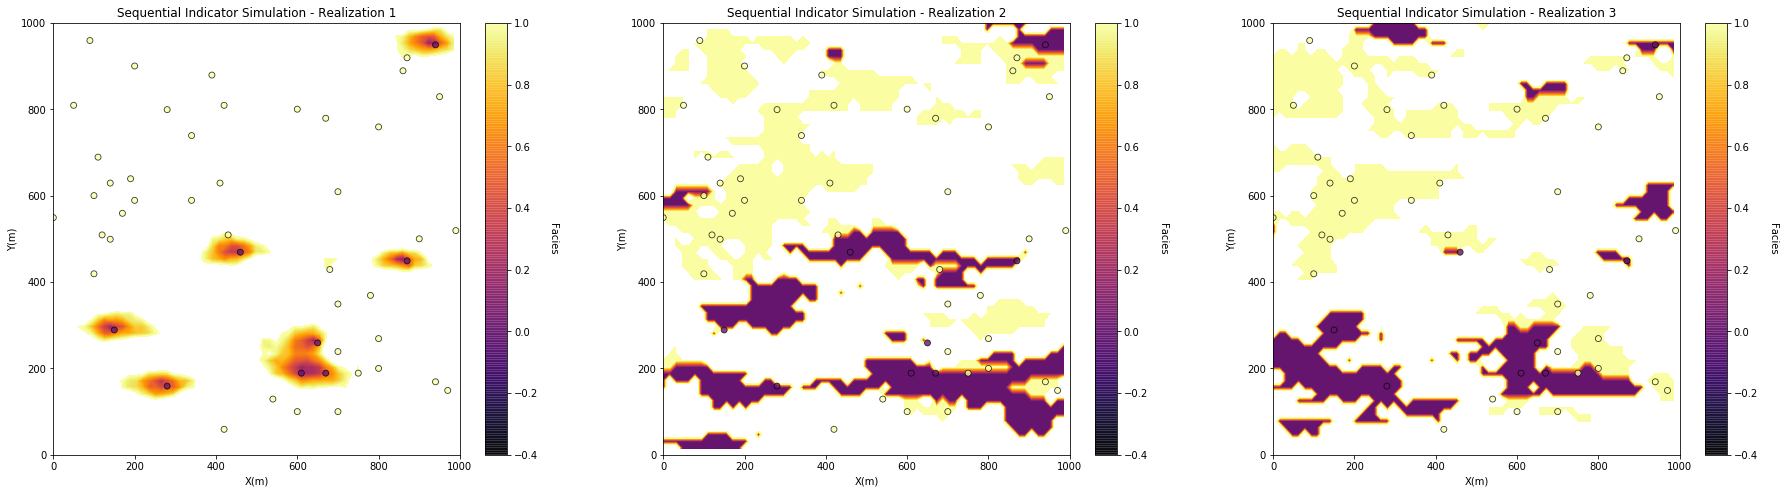

In [202]:
xmin = 0.0; xmax = 1000.0; ymin = 0.0; ymax = 1000.0; cmap = plt.cm.inferno # plotting parameters

plt.subplot(131)                                          # plot the results
GSLIB.locpix_st(np.sum(realizations, axis=0)/n_realizations,xmin,xmax,ymin,ymax,xsiz,-.4,1.0,df,'X','Y','Facies','Sequential Indicator Simulation - Realization 1','X(m)','Y(m)','Facies',cmap)

plt.subplot(132)                                          # plot the results
GSLIB.locpix_st(realizations[1],xmin,xmax,ymin,ymax,xsiz,-.4,1.0,df,'X','Y','Facies','Sequential Indicator Simulation - Realization 2','X(m)','Y(m)','Facies',cmap)

plt.subplot(133)                                          # plot the results
GSLIB.locpix_st(realizations[2],xmin,xmax,ymin,ymax,xsiz,-.4,1.0,df,'X','Y','Facies','Sequential Indicator Simulation - Realization 3','X(m)','Y(m)','Facies',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=4.0, top=1.5, wspace=0.2, hspace=0.2)
plt.show()

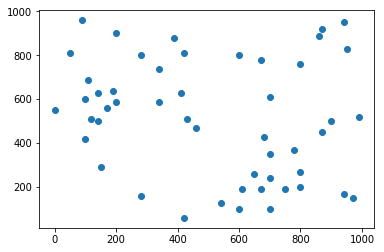

In [203]:
plt.plot(df['X'], df['Y'], 'o') #, c=df['Facies'])

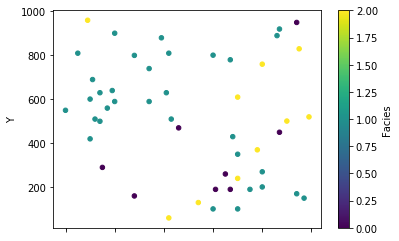

In [204]:
df.plot.scatter(x="X", y="Y", c="Facies", colormap='viridis')

In [205]:


f = open("data_frame_three_facies_2.pkl", mode='wb')
pickle.dump(df, f)
f.close()